In [1]:
import matplotlib.pyplot as plt
plt.rc('figure',titlesize=8);plt.rc('axes',labelsize=8);plt.rc('xtick',labelsize=8);plt.rc('ytick',labelsize=8);plt.rc('legend', fontsize=8);plt.rc('font', size=8);plt.rc('figure', titlesize=10)
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
import warnings
def display_table(x):
    with warnings.catch_warnings() and pd.option_context('display.latex.repr', True):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        display(x)

In [5]:
# %pip install yfinance requests-cache

In [6]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

# Download and Combine Data

In [7]:
gspc = yf.download(tickers='^GSPC', start='1900-01-01', session=session).resample(rule = 'M', kind = 'period').last()

[*********************100%***********************]  1 of 1 completed


In [8]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1900-01-01', session=session)

In [9]:
mkt = ff[0] / 100

Create a dataframe contains "Adj Close", "Mkt-rf", "RF", "All Time High", and "% Relative to All Time High."

In [10]:
ac = pd.DataFrame(gspc, columns = ['Adj Close'])
mkt1 = pd.DataFrame(mkt, columns = ['Mkt-RF', 'RF'])
df = pd.merge( ac, mkt1, how = 'inner', left_index=True, right_index=True)
df['R'] = df['Mkt-RF'] + df['RF']
df['All Time High'] = df['Adj Close'].cummax()
df['% Relative to All Time High'] = 0
for d, m in df.iterrows():
    df.loc[d, '% Relative to All Time High'] = ( df.loc[d, 'Adj Close'] / df.loc[d, 'All Time High']) - 1
df.head(2)

,Adj Close,Mkt-RF,RF,R,All Time High,% Relative to All Time High
Date,,,,,,
1927-12,17.66,0.02,0.00,0.02,17.66,0.00
1928-01,17.57,-0.01,0.00,-0.00,17.66,-0.01


# Implement Strategies

In [11]:
def strategy(BTD): 
    s = BTD.copy()
    s['Cash'] = np.nan; s['Market'] = np.nan; s['Total'] = np.nan
    inv = 1000; cash_bom = 0; mkt_bom = 0

    for date, (Position, RF, R, Market, Cash) in s[['Position', 'RF', 'R', 'Market', 'Cash']].iterrows():
        if Position == 1: # Invest in Market  
            mkt_eom = (cash_bom + mkt_bom + inv) * (1 + R) # Market
            cash_eom = 0 # Cash 
        else: 
            cash_eom = (cash_bom + inv) * (1 + RF) # Cash 
            mkt_eom = mkt_bom * (1 + R) # Market

        cash_bom = cash_eom; mkt_bom = mkt_eom
        s.loc[date,'Market'] = mkt_eom; s.loc[date,'Cash'] = cash_eom
        
    for date, (Cash, Market) in s[['Cash', 'Market']].iterrows():
        s.loc[date, 'Total'] = Cash + Market
        
    return s 

***Strategy One: Dollar-Cost Averaging (DCA)*** 

In [12]:
df1 = df.copy()
df1['Position'] = 1 # (0:Cash, 1: Market)
strategy(df1).head(3)

,Adj Close,Mkt-RF,RF,R,All Time High,% Relative to All Time High,Position,Cash,Market,Total
Date,,,,,,,,,,
1927-12,17.66,0.02,0.00,0.02,17.66,0.00,1,0.00,"1,023.10","1,023.10"
1928-01,17.57,-0.01,0.00,-0.00,17.66,-0.01,1,0.00,"2,014.40","2,014.40"
1928-02,17.26,-0.02,0.00,-0.01,17.66,-0.02,1,0.00,"2,973.10","2,973.10"


***Strategy Two: Buy The Dip 1 (BTD1)*** 

In [13]:
df2 = df.copy()
for d, m in df2.iterrows():
    df2['Position'] = np.select(
        condlist = [df2['% Relative to All Time High'].shift(1) < -.2, df2['% Relative to All Time High'].shift(1) >= -.2],
        choicelist = [1, 0], default = np.nan) # (0:Cash, 1: Market)
strategy(df2).head(3)

,Adj Close,Mkt-RF,RF,R,All Time High,% Relative to All Time High,Position,Cash,Market,Total
Date,,,,,,,,,,
1927-12,17.66,0.02,0.00,0.02,17.66,0.00,NaN,"1,002.20",0.00,"1,002.20"
1928-01,17.57,-0.01,0.00,-0.00,17.66,-0.01,0.00,"2,007.21",0.00,"2,007.21"
1928-02,17.26,-0.02,0.00,-0.01,17.66,-0.02,0.00,"3,017.13",0.00,"3,017.13"


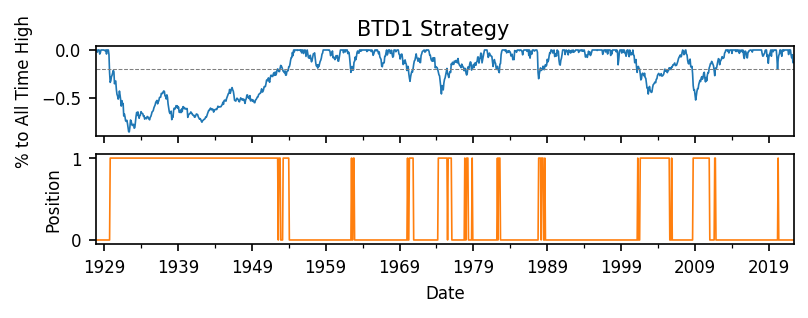

In [14]:
df2_g1 = df2.loc[:, ['% Relative to All Time High','Position']].plot(subplots=True, legend=False, linewidth=0.8, figsize = (6,1.75))
plt.suptitle('BTD1 Strategy'); df2_g1[0].set_ylabel('% to All Time High');df2_g1[1].set_ylabel('Position')
df2_g1[0].axhline(-0.2, **{'color':'grey', 'linestyle':'--'},linewidth=0.5)
plt.show()

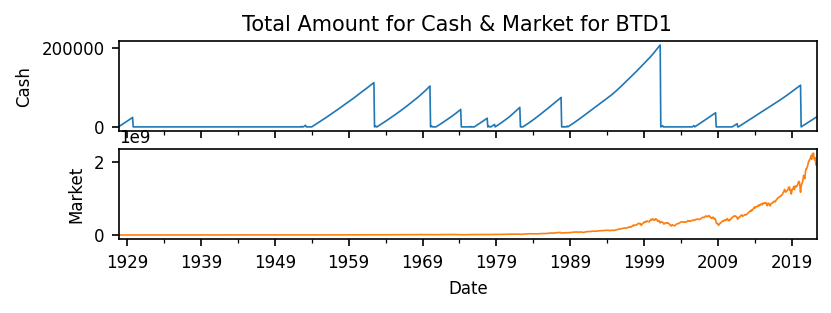

In [15]:
df2_g2 = strategy(df2).loc[:, ['Cash', 'Market']].plot(subplots=True, legend=False, linewidth=0.8, figsize = (6,1.75))
df2_g2[0].set_ylabel('Cash'); df2_g2[1].set_ylabel('Market')
plt.suptitle('Total Amount for Cash & Market for BTD1')
plt.show()

***Strategy Three:Buy The Dip 2 (BTD2)*** 

In [16]:
df3 = df.copy()
for date, dip in df3.iterrows():
    df3['Position'] = np.select(
        condlist=[(df3['% Relative to All Time High'].shift(1) >= 0), 
            (df3['% Relative to All Time High'].shift(1) < -0.2),], 
        choicelist=[0, 1], default=np.nan) #(0: Cash; 1: Market )
df3['Position'].fillna(method='ffill', inplace=True)
df3['Position'].fillna(value = 0, inplace=True, limit = 1)
strategy(df3).head(3) 

,Adj Close,Mkt-RF,RF,R,All Time High,% Relative to All Time High,Position,Cash,Market,Total
Date,,,,,,,,,,
1927-12,17.66,0.02,0.00,0.02,17.66,0.00,0.00,"1,002.20",0.00,"1,002.20"
1928-01,17.57,-0.01,0.00,-0.00,17.66,-0.01,0.00,"2,007.21",0.00,"2,007.21"
1928-02,17.26,-0.02,0.00,-0.01,17.66,-0.02,0.00,"3,017.13",0.00,"3,017.13"


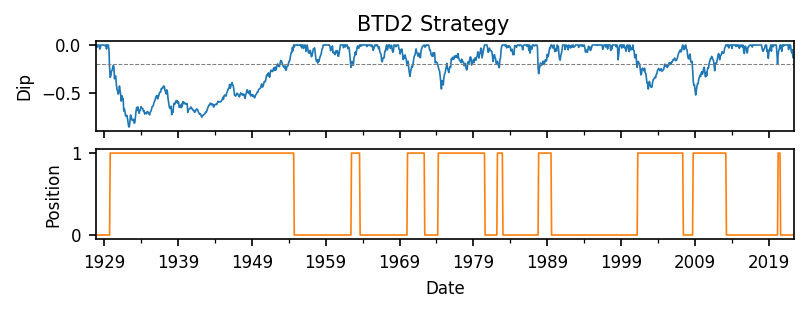

In [17]:
df3_g1 = df3.loc[:, ['% Relative to All Time High','Position']].plot(subplots=True, legend=False, figsize = (6,1.75), linewidth=0.8)
df3_g1[0].set_ylabel('Dip'); df3_g1[1].set_ylabel('Position')
df3_g1[0].axhline(-0.2, **{'color':'grey', 'linestyle':'--'},linewidth=0.5); plt.suptitle('BTD2 Strategy')
plt.show()

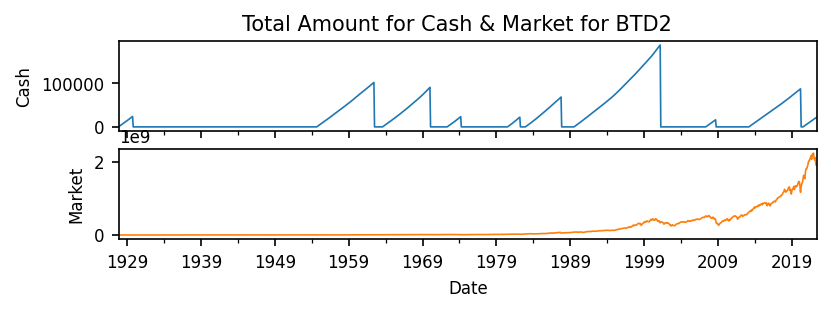

In [18]:
df3_g2 = strategy(df3).loc[:, ['Cash', 'Market']].plot(subplots=True, legend=False,linewidth=0.8, figsize = (6,1.75))
df3_g2[0].set_ylabel('Cash'); df3_g2[1].set_ylabel('Market')
plt.suptitle('Total Amount for Cash & Market for BTD2')
plt.show()

# Full Sample Evaluation, Ranking, and Discussion

***Analysis:***

Over the entire period from 1927 through 2022, the DCA strategy which invests regardless of market conditions slightly outperformed both of the 'Buy the Dip' strategies. Intuitively, this is due to the fact that the timing of initial investment over the long term does not drastically effect the overall returns. Each of the three strategies are shown below:

In [19]:
Return_DCA = pd.DataFrame(strategy(df1), columns = ['Total'])
Return_BTD1 = pd.DataFrame(strategy(df2), columns = ['Total'])
Return_BTD2 = pd.DataFrame(strategy(df3),columns = ['Total'])
Return_All = Return_DCA.merge(Return_BTD1, on='Date').merge(Return_BTD2, on='Date')
Return_All.columns = ['Total_DCA', 'Total_BTD1', 'Total_BTD2']
Return_All.tail(3)

,Total_DCA,Total_BTD1,Total_BTD2
Date,,,
2022-03,"2,123,519,174.54","2,108,338,849.94","2,113,310,137.71"
2022-04,"1,922,847,518.05","1,909,104,002.65","1,913,605,220.00"
2022-05,"1,916,887,687.64","1,903,186,862.16","1,907,674,115.53"


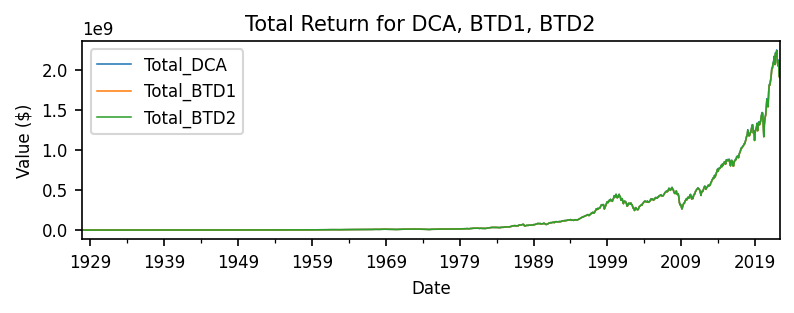

In [20]:
Return_All.plot(figsize = (6,1.75), lw = 0.75)
plt.suptitle('Total Return for DCA, BTD1, BTD2')
plt.xlabel('Date'); plt.ylabel('Value ($)')
plt.show()

In [21]:
Return_All.loc['2022-05'].sort_values(ascending=False)

Total_DCA    1,916,887,687.64
Total_BTD2   1,907,674,115.53
Total_BTD1   1,903,186,862.16
Name: 2022-05, dtype: float64

To dig a little further into the slight discrepancy in performance, we can look at the market performance over the periods each of the BTD strategies were holding cash:

In [22]:
Signal_BTD1 = pd.DataFrame(df2, columns = ['R','Position'])
Signal_BTD2 = pd.DataFrame(df3,columns = ['Position'])
Signals_All = Signal_BTD1.merge(Signal_BTD2, on='Date', suffixes = ['_BTD1', '_BTD2'])
BTD1_OppCost = Signals_All[Signals_All['Position_BTD1']==0]
BTD2_OppCost = Signals_All[Signals_All['Position_BTD2']==0]
print('BTD1 Average Monthly Return in Market (when investing in cash): '+" "+str(BTD1_OppCost['R'].mean()))
print('BTD2 Average Monthly Return in Market (when investing in cash): '+" "+str(BTD2_OppCost['R'].mean()))
print('BTD1 total months when investing in cash: '+" "+str(BTD1_OppCost['R'].count()))
print('BTD2 total months when investing in cash: '+" "+str(BTD2_OppCost['R'].count()))

BTD1 Average Monthly Return in Market (when investing in cash):  0.009030501392757661
BTD2 Average Monthly Return in Market (when investing in cash):  0.00834018018018018
BTD1 total months when investing in cash:  718
BTD2 total months when investing in cash:  555


This Analysis shows us that over the period, the buy the dip strategies while investing in cash were taking an average opportunity cost of around 1% per month.

Additionally, the discrepancy between the opportunity costs of the two strategies above would initially infer that BTD1 outperformed BTD2, seeing as the opportunity cost of of BTD1 is smaller than that of BTD2, however, this can be explained by the number of periods within the analysis. BTD1 has 164 more periods in which the strategy does not invest in the market, explaining the slight discrepancy. But note that the overall difference between strategies was negligible, as the vast majority of total performance was driven by cash invested early in the period. The compounded opportunity cost is still marginal in comparison to the returns realized by each strategy.

Finally, we can graph the total cumulative product of the non-investment period returns to adjust for this discrepancy and get a visual of the return data the investment strategies missed out on:

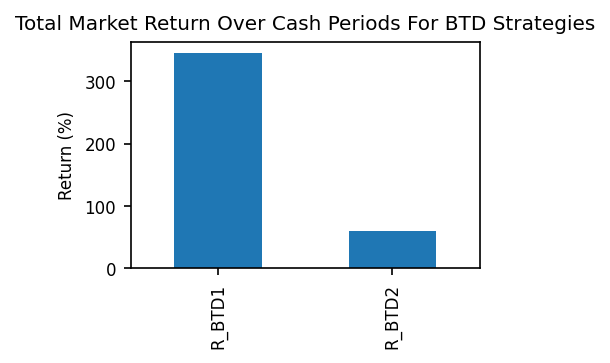

In [23]:
BTD1_TotalOpp = pd.DataFrame(BTD1_OppCost['R'].add(1).cumprod()-1)
BTD2_TotalOpp = pd.DataFrame(BTD2_OppCost['R'].add(1).cumprod()-1)
TotalOppCost = BTD1_TotalOpp.merge(BTD2_TotalOpp, on='Date', suffixes=['_BTD1', '_BTD2'])
TotalOppCost.loc['2022-05'].plot(kind='bar', figsize=(3,2))
plt.title('Total Market Return Over Cash Periods For BTD Strategies'); plt.ylabel('Return (%)')
plt.show()

# Rolling 20-Year Window Evaluation, Ranking, and Discussion

In [24]:
def strategyRolling(BTD): 
    s = BTD.copy() 
    s['Cash'] = np.nan; s['Market'] = np.nan; s['Total'] = np.nan
    inv = 1000; cash_bom = 0; mkt_bom = 0
    
    for date, (Position, RF, R, Market, Cash) in s[['Position', 'RF', 'R', 'Market', 'Cash']].iterrows():
        if Position == 1: # Invest in Market  
            mkt_eom = (cash_bom + mkt_bom + inv) * (1 + R) # Market
            cash_eom = 0 # Cash 
        else: 
            cash_eom = (cash_bom + inv) * (1 + RF) # Cash 
            mkt_eom = mkt_bom * (1 + R) # Market
        
        cash_bom = cash_eom; mkt_bom = mkt_eom
        s.loc[date,'Market'] = mkt_eom; s.loc[date,'Cash'] = cash_eom
        
    for date, (Cash, Market) in s[['Cash', 'Market']].iterrows():
        s.loc[date, 'Total'] = Cash + Market
        
    return pd.DataFrame(s.iloc[-1])

In [25]:
Rolling_DCA =  pd.concat([strategyRolling(date).loc['Total'] for date in df1.rolling(240, min_periods = 240)]).iloc[240:]
Rolling_BTD_1 = pd.concat([strategyRolling(date).loc['Total'] for date in df2.rolling(240, min_periods = 240)]).iloc[240:]
Rolling_BTD_2 = pd.concat([strategyRolling(date).loc['Total'] for date in df3.rolling(240, min_periods = 240)]).iloc[240:]
Rolling_DCA = pd.DataFrame(Rolling_DCA)
Rolling_BTD_1 = pd.DataFrame(Rolling_BTD_1)
Rolling_BTD_2 = pd.DataFrame(Rolling_BTD_2)
Rolling_All = Rolling_DCA.merge(Rolling_BTD_1, left_index=True, right_index=True).merge(Rolling_BTD_2, left_index=True, right_index=True)
Rolling_All.columns=['DCA','BTD1','BTD2']
Rolling_All.head(3)

,DCA,BTD1,BTD2
1947-12,"570,945.48","570,645.80","570,645.80"
1948-01,"547,610.28","547,749.79","547,749.79"
1948-02,"522,795.06","523,351.47","523,351.47"


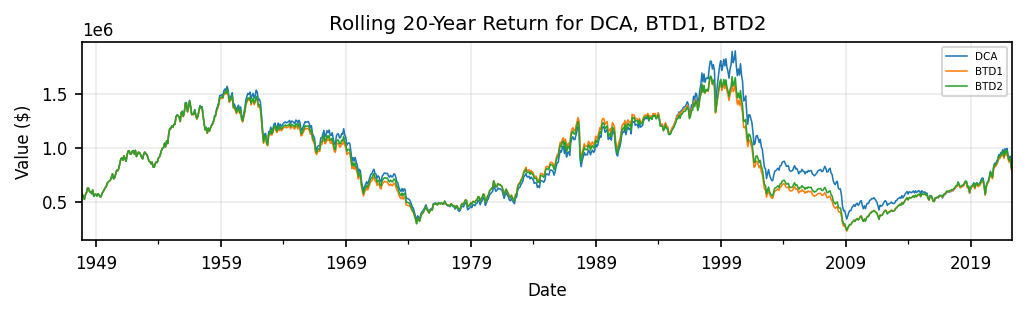

In [26]:
Rolling_All.plot(figsize=(8,1.75), linewidth=0.75)
plt.title('Rolling 20-Year Return for DCA, BTD1, BTD2');plt.xlabel('Date')
plt.ylabel('Value ($)'); plt.legend(fontsize = 5); plt.grid(linewidth = 0.2)
plt.show()

The above graph of the rolling 20-year strategies shows each strategy's performance for the 20 year period ending at the final date. So the 2009 value graphed above represents the investment period ending in 2009. Looking at this graph, it would appear as though the DCA strategy outperformed both BTD strategies on average. To get a closer look at this, we can use the DCA strategy as a benchmark and graph the difference between it and the other strategies:

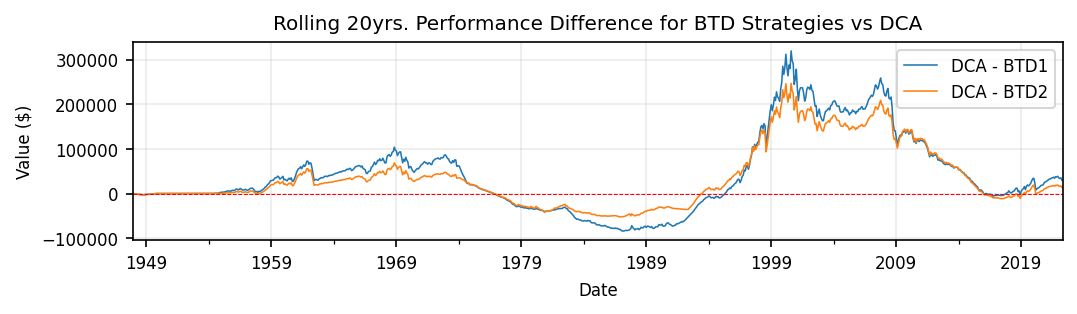

In [27]:
Rolling_All['DCA - BTD1'] = Rolling_All['DCA']-Rolling_All['BTD1']
Rolling_All['DCA - BTD2'] = Rolling_All['DCA']-Rolling_All['BTD2']
Rolling_Difference = Rolling_All[['DCA - BTD1','DCA - BTD2']]

Rolling_Difference.plot(figsize=(8,1.75), linewidth=0.75)
plt.title('Rolling 20yrs. Performance Difference for BTD Strategies vs DCA')
plt.xlabel('Date'); plt.ylabel('Value ($)'); plt.grid(linewidth=0.2)
plt.axhline(y=0, color='red', linestyle='--',linewidth=0.5)
plt.show()

Based on the graph above, when each of the DCA-BTD strategy differences are greater than zero, the DCA strategy outperformed the other strategies across almost all continuous 20 year combinations. Based on this information, the DCA strategy is on average the best performer in 20-year windows, the BTD2 strategy is on average the second best performer, and the BTD1 strategy is on average the worst of the three.